# Variational Autoencoders
Build a Convolutional Variational AutoEncoder and achieve best possible reconstruction and latent space disentanglement. Then answer the questions.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchsummary import summary

import matplotlib.pyplot as plt
import pandas as pd
import altair as alt

In [2]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [4]:
# Load the data

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

#                 ** MODIFY CODE HERE IF NECESSARY **

batch_size = 100

data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

def denormalize(x):
    return x

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms,
)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

# Download test data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms,
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
)

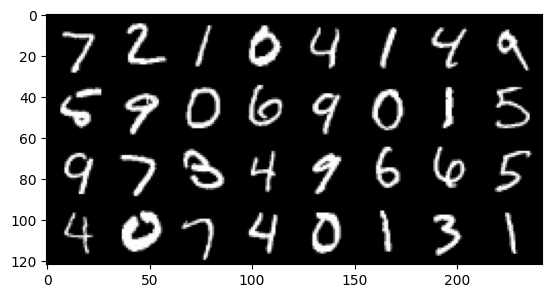

In [5]:
sample_inputs, _ = next(iter(test_dataloader))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denormalize(fixed_input), nrow=8, padding=2, normalize=False,
                scale_each=False, pad_value=0)
plt.figure()
show(img)

# Variational Auto Encoders (VAEs)

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">2</a>.
  </figcaption>
</figure>

## Build a convolutional VAE (5 points)

The only requirement is that it contains convolutions both in the encoder and decoder. You can still use some linear layers if needed.

In [6]:
# Convolutional VAE implementation here
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2), # 14x14
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2), # 7x7,
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Flatten(),
        )

        self.linear_mu = nn.Linear(7*7*128, self.latent_dim)
        self.linear_logvar = nn.Linear(7*7*128, self.latent_dim)
        self.linear_up = nn.Linear(self.latent_dim, 7*7*128)

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1), # 7x7
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2), # 14x14
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2), # 28x28
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Sigmoid(),
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        x = self.encoder(x)
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        std = torch.exp(0.5*logvar)
        epsilon = torch.randn(std.size())
        epsilon = epsilon.to(device)
        return (mu + std*epsilon)

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        z = self.linear_up(z)
        z = z.view(-1, 128, 7, 7)
        z = self.decoder(z)
        z = z.reshape(-1, 784)

        return z

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # print(x.shape)
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return mu, logvar, self.decode(z)


        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

latent_dim = 10 # experiment with this!
model = VAE(latent_dim).to(device)
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 6272]                --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          640
|    └─LeakyReLU: 2-2                    [-1, 64, 28, 28]          --
|    └─Conv2d: 2-3                       [-1, 128, 28, 28]         73,856
|    └─LeakyReLU: 2-4                    [-1, 128, 28, 28]         --
|    └─MaxPool2d: 2-5                    [-1, 128, 14, 14]         --
|    └─Conv2d: 2-6                       [-1, 128, 14, 14]         147,584
|    └─LeakyReLU: 2-7                    [-1, 128, 14, 14]         --
|    └─MaxPool2d: 2-8                    [-1, 128, 7, 7]           --
|    └─Conv2d: 2-9                       [-1, 128, 7, 7]           147,584
|    └─LeakyReLU: 2-10                   [-1, 128, 7, 7]           --
|    └─Flatten: 2-11                     [-1, 6272]                --
├─Linear: 1-2                            [-1, 10]                  62,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 6272]                --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          640
|    └─LeakyReLU: 2-2                    [-1, 64, 28, 28]          --
|    └─Conv2d: 2-3                       [-1, 128, 28, 28]         73,856
|    └─LeakyReLU: 2-4                    [-1, 128, 28, 28]         --
|    └─MaxPool2d: 2-5                    [-1, 128, 14, 14]         --
|    └─Conv2d: 2-6                       [-1, 128, 14, 14]         147,584
|    └─LeakyReLU: 2-7                    [-1, 128, 14, 14]         --
|    └─MaxPool2d: 2-8                    [-1, 128, 7, 7]           --
|    └─Conv2d: 2-9                       [-1, 128, 7, 7]           147,584
|    └─LeakyReLU: 2-10                   [-1, 128, 7, 7]           --
|    └─Flatten: 2-11                     [-1, 6272]                --
├─Linear: 1-2                            [-1, 10]                  62,

Briefly Explain your architectural choices

<font color='red'>***YOUR ANSWER***</font>

## Defining a Loss

The Beta VAE loss, with encoder $q$ and decoder $p$:
$$ L=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

The loss you implement depends on your choice of latent prior and model outputs.

There exist different solutions that are equally correct. Depending on your assumptions you might want to do a data preprocessing step.



In [7]:
def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # We can use binary cross entropy to calculate the loss between the
        # original image x and the reconstructed one.
        BCE_loss = F.binary_cross_entropy(recon_x, x, reduction="sum")
        # MSE_loss = torch.pow(recon_x - x,2).sum()
        # The following is KL divergence term. (The prior is assumed a Normal
        # Gaussian distribution)
        KL_divergence = 0.5*torch.sum(1+logvar-mu**2-torch.exp(logvar))

        return BCE_loss, -beta*KL_divergence

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

## Train and plot

Train the VAE and plot:

1.   The total loss curves for train and test (on the same plot)
2.   The reconstruction losses for train and test (on the same plot)
3.   The KL losses for train and test (on the same plot)

(x-axis: epochs, y-axis: loss)

You may want to have different plots with differente values of $\beta$.

Hint: You can modify the training scripts provided in previous tutorials to record the required information, and use matplotlib to plot them

In [8]:
# Training code

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

from torch.utils.data import DataLoader, sampler
from torch.optim.lr_scheduler import CosineAnnealingLR

latent_dim = 20
num_epochs = 30
beta=0.7

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# cosine annealing scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

train_reconstruction_losses = []
train_KL_losses = []
train_tot_losses = []

test_reconstruction_losses = []
test_KL_losses = []
test_tot_losses = []

# Convolutional implementation training
for epoch in range(num_epochs):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Train
        epoch_reconstruction_loss = 0
        epoch_KL_loss = 0
        epoch_tot_loss = 0

        for t, (x, _) in enumerate(loader_train):

            optimizer.zero_grad()
            x = x.to(device=device)
            mu, logvar, recon_x, = model(x)

            reconstruction_loss, KL_loss = loss_function_VAE(recon_x, x.reshape(-1,784), mu, logvar, beta)
            tot_loss = reconstruction_loss + KL_loss

            tot_loss.backward()
            optimizer.step()

            epoch_reconstruction_loss += reconstruction_loss.item()
            epoch_KL_loss += KL_loss.item()
            epoch_tot_loss += tot_loss.item()

        train_reconstruction_losses.append(epoch_reconstruction_loss/len(loader_train.dataset))
        train_KL_losses.append(epoch_KL_loss/len(loader_train.dataset))
        train_tot_losses.append(epoch_tot_loss/len(loader_train.dataset))

        print("Epoch: %d, train loss = %.4f" % (epoch, train_tot_losses[-1]))

        # Test
        test_reconstruction_loss = 0
        test_KL_loss = 0
        test_tot_loss = 0

        with torch.no_grad():
            for (x_test, _) in loader_test:
                x_test = x_test.to(device=device)
                mu_test, logvar_test, recon_x_test = model(x_test)
                x_test_flat = x_test.reshape(-1, 784)
                recon_x_test_flat = recon_x_test.reshape(-1, 784)
                reconstruction_loss, KL_loss = loss_function_VAE(
                    recon_x_test_flat, x_test_flat, mu_test, logvar_test, beta
                )
                test_loss = reconstruction_loss + KL_loss

                test_reconstruction_loss += reconstruction_loss.item()
                test_KL_loss += KL_loss.item()
                test_tot_loss += test_loss.item()

        test_tot_losses.append(test_tot_loss / len(loader_test.dataset))
        test_reconstruction_losses.append(test_reconstruction_loss / len(loader_test.dataset))
        test_KL_losses.append(test_KL_loss / len(loader_test.dataset))

        print("Epoch: %d, test loss = %.4f" % (epoch, test_tot_losses[-1]))

        scheduler.step()

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

Total number of parameters is: 992425
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (linear_mu): Linear(in_features=6272, out_features=20, bias=True)
  (linear_logvar): Linear(in_features=6272, out_features=20, bias=True)
  (linear_up): Linear(in_features=20, out_features=6272, bias=True)
  (decoder): Sequential(
    (0): Conv2d(128,

Epoch: 0, train loss = 148.4698
Epoch: 0, test loss = 99.7536
Epoch: 1, train loss = 97.2401
Epoch: 1, test loss = 93.9992
Epoch: 2, train loss = 93.6929
Epoch: 2, test loss = 92.6525
Epoch: 3, train loss = 92.0959
Epoch: 3, test loss = 91.4436
Epoch: 4, train loss = 91.0435
Epoch: 4, test loss = 90.5433
Epoch: 5, train loss = 90.2726
Epoch: 5, test loss = 89.8494
Epoch: 6, train loss = 89.5782
Epoch: 6, test loss = 89.0057
Epoch: 7, train loss = 89.0881
Epoch: 7, test loss = 88.4742
Epoch: 8, train loss = 88.5922
Epoch: 8, test loss = 88.6028
Epoch: 9, train loss = 88.2361
Epoch: 9, test loss = 88.1029
Epoch: 10, train loss = 87.7972
Epoch: 10, test loss = 87.8247
Epoch: 11, train loss = 87.4597
Epoch: 11, test loss = 87.2645
Epoch: 12, train loss = 87.1980
Epoch: 12, test loss = 87.5969
Epoch: 13, train loss = 86.8362
Epoch: 13, test loss = 87.0936
Epoch: 14, train loss = 86.5639
Epoch: 14, test loss = 86.6136
Epoch: 15, train loss = 86.3281
Epoch: 15, test loss = 86.4480
Epoch: 16, 

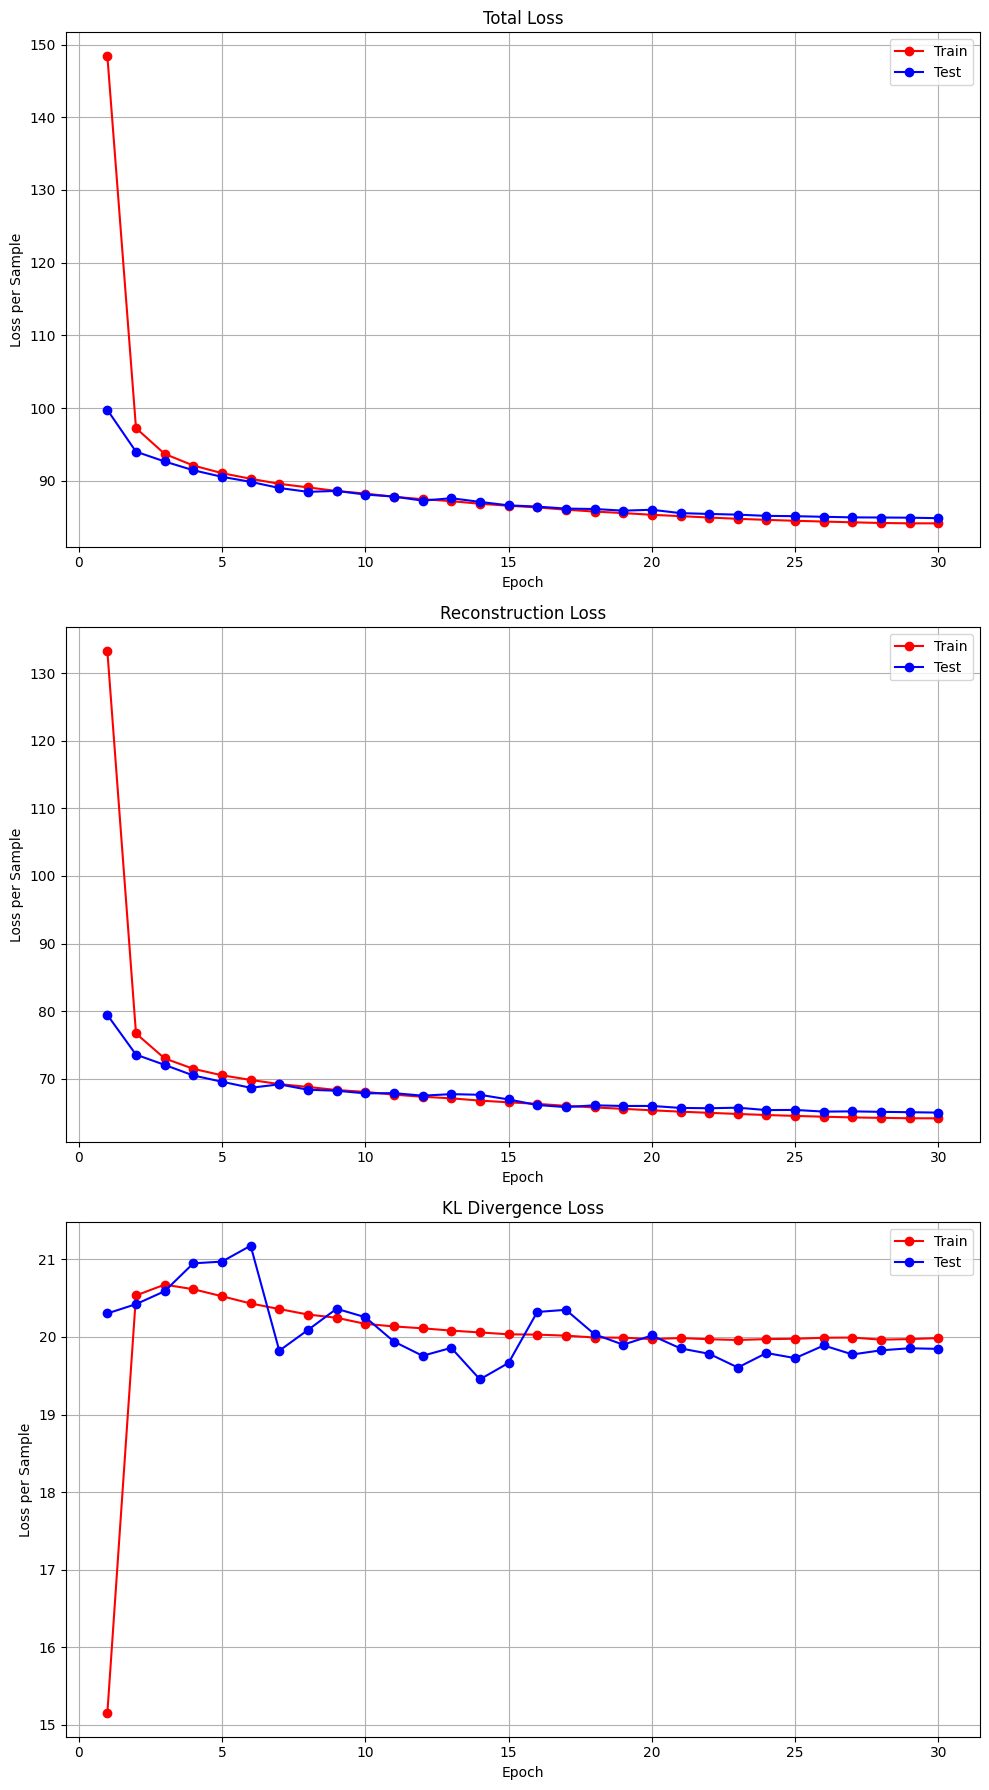

In [9]:
#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Total Loss
axs[0].plot(epochs, train_tot_losses, "-ro", label="Train")
axs[0].plot(epochs, test_tot_losses, "-bo", label="Test")
axs[0].set_title("Total Loss")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss per Sample')
axs[0].legend()
axs[0].grid(True)

# Reconstruction Loss
axs[1].plot(epochs, train_reconstruction_losses, "-ro", label="Train")
axs[1].plot(epochs, test_reconstruction_losses, "-bo", label="Test")
axs[1].set_title("Reconstruction Loss")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss per Sample')
axs[1].legend()
axs[1].grid(True)

# KL Divergence Loss
axs[2].plot(epochs, train_KL_losses, "-ro", label="Train")
axs[2].plot(epochs, test_KL_losses, "-bo", label="Test")
axs[2].set_title("KL Divergence Loss")
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss per Sample')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

Observe:

1.   Loss curves (reconstruction and KL divergence)
2.   How different values of $\beta$ affect your training.




## Sample and reconstruction quality
Simply run the below cell to visualize the output

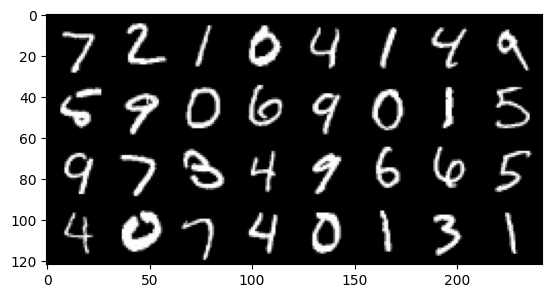

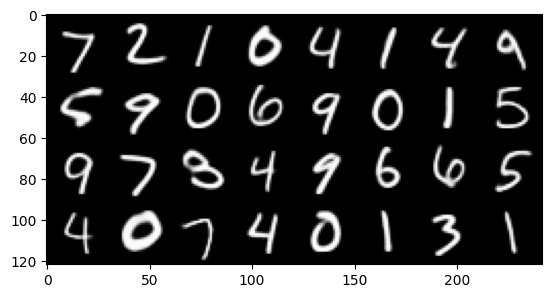

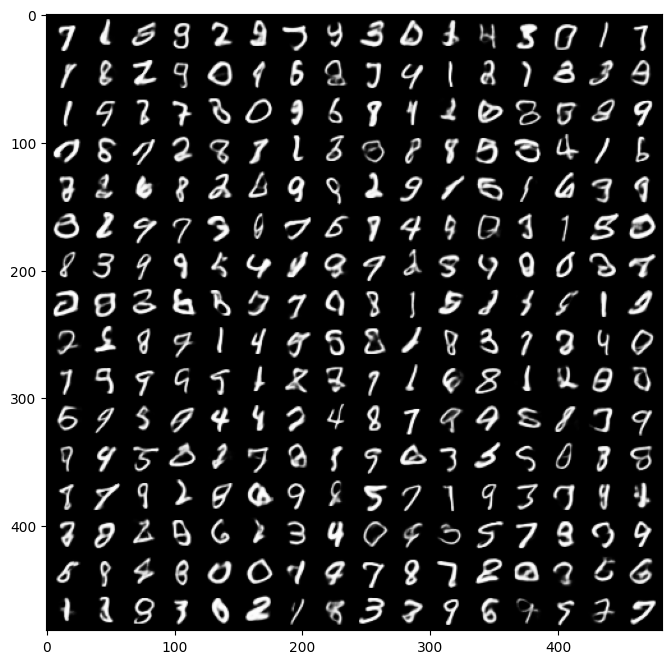

In [10]:
# Input images
model.eval()
sample_inputs, _ = next(iter(test_dataloader))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denormalize(fixed_input), nrow=8, padding=2, normalize=False,
                scale_each=False, pad_value=0)
plt.figure()
show(img)

# Reconstructed images
with torch.no_grad():

    _, _, recon_batch = model(sample_inputs.to(device))
    recon_batch = recon_batch.unsqueeze(1).reshape(-1,1,28,28)
    recon_batch = recon_batch[0:32, :, :, :]
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denormalize(recon_batch), nrow=8, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

# Generated Images
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():

    samples = model.decode(z)
    samples = samples.unsqueeze(1).reshape(-1,1,28,28)
    samples = samples.cpu()
    samples = make_grid(denormalize(samples), nrow=16, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

## T-SNE on Embeddings (5 points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

Run the below cells (no coding required).

Qualitatively assess the learned representations of your model using the T-SNE plots.


In [11]:
alt.data_transformers.disable_max_rows()

def plot_tsne(tsne_xy, dataloader, num_points=1000):

    images, labels = zip(*[(x[0].numpy()[0,:,:,None], x[1]) for x in dataloader.dataset])

    num_points = min(num_points, len(labels))
    data = pd.DataFrame({'x':tsne_xy[:, 0], 'y':tsne_xy[:, 1], 'label':labels,
                        'image': images})
    data = data.sample(n=num_points, replace=False)

    alt.renderers.set_embed_options('light')
    selection = alt.selection_single(on='mouseover', clear='false', nearest=True,
                                    init={'x':data['x'][data.index[0]], 'y':data['y'][data.index[0]]})
    # selection = alt.sel (on='mouseover', clear='false', nearest=True,
    #                                 init={'x':data['x'][data.index[0]], 'y':data['y'][data.index[0]]})
    scatter = alt.Chart(data).mark_circle().encode(
        alt.X('x:N',axis=None),
        alt.Y('y:N',axis=None),
        color=alt.condition(selection,
                            alt.value('lightgray'),
                            alt.Color('label:N')),
        size=alt.value(100),
        tooltip='label:N'
    ).add_selection(
        selection
    ).properties(
        width=400,
        height=400
    )

    digit  = alt.Chart(data).transform_filter(
        selection
    ).transform_window(
        index='count()'           # number each of the images
    ).transform_flatten(
        ['image']                 # extract rows from each image
    ).transform_window(
        row='count()',            # number the rows...
        groupby=['index']         # ...within each image
    ).transform_flatten(
        ['image']                 # extract the values from each row
    ).transform_window(
        column='count()',         # number the columns...
        groupby=['index', 'row']  # ...within each row & image
    ).mark_rect(stroke='black',strokeWidth=0).encode(
        alt.X('column:O', axis=None),
        alt.Y('row:O', axis=None),
        alt.Color('image:Q',sort='descending',
            scale=alt.Scale(scheme=alt.SchemeParams('lightgreyteal',
                            extent=[1, 0]),

            ),
            legend=None
        ),
    ).properties(
        width=400,
        height=400,
    )

    return scatter | digit

In [12]:
# TSNE
from sklearn.manifold import TSNE

for t, (x, y) in enumerate(test_dataloader):
    if t == 0:
        data = x
        labels = y
    else:
        data = torch.cat((data, x))
        labels = torch.cat((labels, y))

# Then let's apply dimensionality reduction with the trained encoder

with torch.no_grad():
    data = data.to(device)
    mu, logvar = model.encode(data)
    z = (model.reparametrize(mu, logvar)).cpu().detach().numpy()

z_embedded = TSNE(n_components=2).fit_transform(z)

In [13]:
plot_tsne(z_embedded, test_dataloader, num_points=1000)

/cs/student/msc/aibh/2024/gcosta/.local/lib/python3.10/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.HConcatChart(...)

### Discussion
Analyze and discuss the visualized T-SNE representations

1. What role do the KL loss term and $\beta$ have?
2. Can you find any outliers?

## Interpolating in $z$
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from one digit to the other?


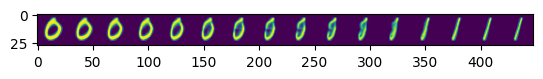

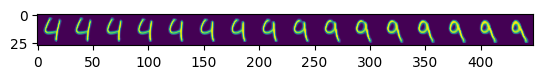

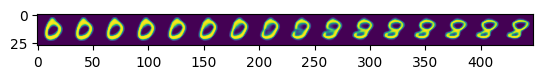

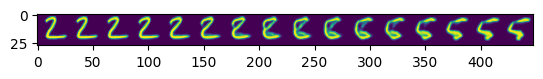

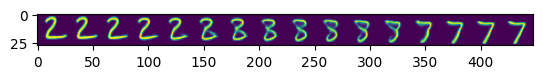

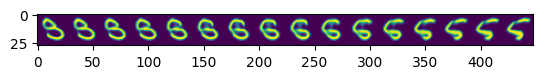

In [14]:
# Interpolate digits
#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

def interpolate(model, a, b):
    x_a = data[labels == a][0]
    x_b = data[labels == b][0]

    with torch.no_grad():
        x_a = x_a.to(device).unsqueeze(1)
        x_b = x_b.to(device).unsqueeze(1)
        mu, logvar = model.encode(x_a)
        z_a = (model.reparametrize(mu, logvar))
        mu, logvar = model.encode(x_b)
        z_b = (model.reparametrize(mu, logvar))

    z = torch.stack([(1.0 - n) *z_a + n*z_b for n in np.linspace(0, 1, 16)])
    z_interpolated = model.decode(z).cpu().detach().numpy()
    img = np.zeros((28, 16*28))

    for i, x_ in enumerate(z_interpolated):
        img[:, i*28:(i+1)*28] = x_.reshape(28,28)
    plt.imshow(img)
    plt.show()

interpolate(model, 0, 1)
interpolate(model, 4, 9)
interpolate(model, 0, 8)
interpolate(model, 2, 5)
interpolate(model, 2, 7)
interpolate(model, 3, 5)

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################